# **Road Damage Detection with CV**

**created by Thewavewy Piyounggul Suparsorn**

Project นี้จะเป็นการสร้าง Machine Learning Model ในการคัดแยกส่วนของถนนที่ความเสียหายเกินกว่าที่รับได้ ต้องได้รับการแก้ไข

โดยจะใช้หลัก Convolutional Neural Network : CNN มาใช้สร้าง Model เพื่อเรียนรู้แต่ละ pixel ของถนนโดยข้อมูลที่มช้ train เป็นข้อมูลภาพที่ได้จาก  LCMS และทดสอบโดยใช้ ROMDAS

**สิ่งที่ต้องแก้**


*   ปรับ accuracy ให้ได้เกิน 80 %
*   สามารถแยกชนิดพื้นผิวของถนนได้ (คอนกรีต, ลาดยาง)
*   ใช้ได้ดีกับอีก Test Case (ROMDAS)



# **Test with LCMS**

**environment setup**

In [ ]:
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models as models
from sklearn.metrics import confusion_matrix

# To guarantee reproducible results
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(2)

**Check GPU Status**

In [ ]:
!nvidia-smi

Tue Aug  1 10:06:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

 **Import Dataset**

In [ ]:
! gdown --id 1fNTCMqZFs_DzbZIQq_GKZb0J4jyshNAH
#https://drive.google.com/file/d/1fNTCMqZFs_DzbZIQq_GKZb0J4jyshNAH/view?usp=sharing
!unzip -qo DataTest_lcms.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1fNTCMqZFs_DzbZIQq_GKZb0J4jyshNAH
To: /content/DataTest_lcms.zip
100% 427M/427M [00:06<00:00, 63.6MB/s]


In [ ]:
### Helper function to display image from dataset ###
def getImageFromDataset(dataset, idx):
  sampleImage, sampleLabel = dataset.__getitem__(idx)
  ### Revert transformation ###
  sampleImage = ((sampleImage.permute(1,2,0).numpy() * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]))*255
  sampleImage = sampleImage.astype(np.uint8)
  sampleClassName = dataset.classes[sampleLabel]
  return sampleImage, sampleClassName

In [ ]:
### Dataset Augmentation (https://pytorch.org/docs/stable/torchvision/transforms.html) ###
transformTrain = transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(size=(224,224)),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

transformTest =  transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.CenterCrop(size=(224,224)),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])


In [ ]:
### Dataloader for our dataset ###
resizeTrainDataset = ImageFolder('/content/DataTest/Train',transform = transformTrain)
resizeTestDataset = ImageFolder('/content/DataTest/Test',transform = transformTest)

print('Total train set images :', len(resizeTrainDataset))
print('Total test set images :', len(resizeTestDataset))

Total train set images : 6185
Total test set images : 104


In [ ]:
def visualize_dataset(dataset, num_images=5):
    # Select random indices from the dataset
    indices = np.random.choice(len(dataset), size=num_images, replace=False)

    # Create a grid of subplots to display the images
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))

    # Iterate over the selected indices and plot the images
    for i, idx in enumerate(indices):
        image, label = dataset[idx]

        # Convert image from tensor to NumPy array and transpose dimensions if necessary
        if isinstance(image, torch.Tensor):
            image = image.numpy().transpose((1, 2, 0))

        # Plot the image
        axes[i].imshow(image)
        if label == 1:
          label = 'Normal'
        else:
          label = 'Abnormal'
        axes[i].set_title(label)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


**visualize the dataset**

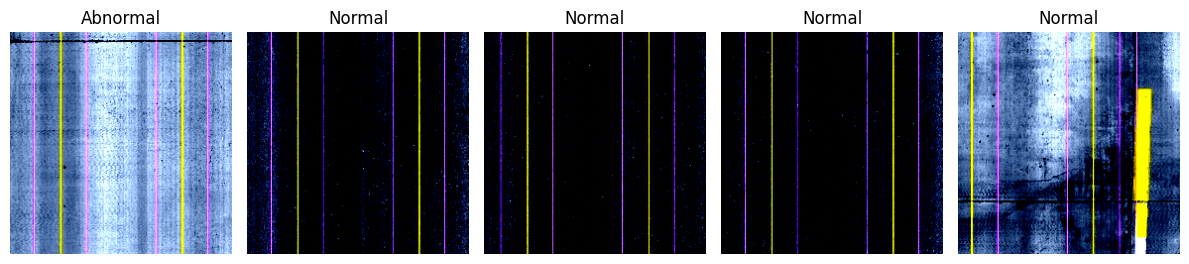

In [ ]:
visualize_dataset(resizeTrainDataset,5)

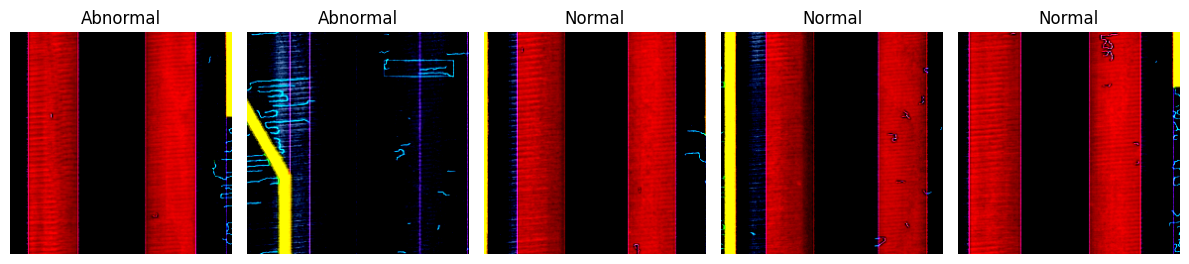

In [ ]:
visualize_dataset(resizeTestDataset,5)

**Build CNN Model based on VGG-8**

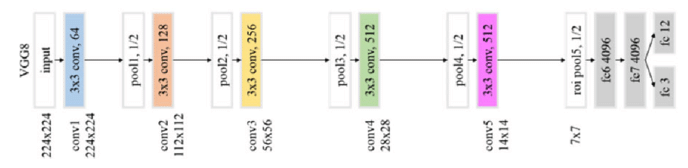

In [ ]:
### Build simple CNN ###
class pneumoniaNet(nn.Module):
  def __init__(self):
    super(pneumoniaNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


    self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.pool5_1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.pool5_2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc6 = nn.Linear(512*7*7, 4096) ### (inputnode=25088, outputnode=4096)
    self.fc7 = nn.Linear(4096, 2)


  def forward(self, input): # 1 x 3 x 224 x 224
    x = self.pool1(F.relu(self.conv1(input)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.pool3(F.relu(self.conv3(x)))
    x = self.pool4(F.relu(self.conv4(x)))

    x_5_1 = self.pool5_1(F.relu(self.conv5_1(x)))
    x_5_2 = self.pool5_2(F.relu(self.conv5_2(x)))

    x = x_5_1 + x_5_2 ### output size of this line is (512,7,7)
    x = x.view(-1, 512*7*7) ### change to (1,25088)

    x = F.relu(self.fc6(x))
    x = self.fc7(x)
    return x

**Construct the model, optimizer and loss function**

In [ ]:
pneuNet = pneumoniaNet()

In [ ]:
output = pneuNet(torch.zeros((1,3,224,224)))

In [ ]:
output

tensor([[-0.0095,  0.0028]], grad_fn=<AddmmBackward0>)

In [ ]:
pneuNet = pneumoniaNet()
pneuNet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pneuNet.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

resizeTrainDatasetLoader = DataLoader(resizeTrainDataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
resizeTestDatasetLoader = DataLoader(resizeTestDataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**train model**

In [ ]:
def testModel(testDatasetLoader, net):
  net.eval()
  correctImages = 0
  totalImages = 0
  allLabels = []
  allPredicted = []
  testingProgressbar = tqdm(enumerate(testDatasetLoader), total=len(testDatasetLoader))
  with torch.no_grad():
    for batchIdx, batchData in testingProgressbar:
      images, labels = batchData

      images, labels = images.cuda(), labels.cuda()
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)

      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      testingProgressbar.set_description("Testing accuracy: {}".format(accumulateAccuracy ) )

      allLabels.append(labels)
      allPredicted.append(predicted)
  allLabels = torch.cat(allLabels).cpu().numpy()
  allPredicted = torch.cat(allPredicted).cpu().numpy()
  return correctImages, totalImages, allLabels, allPredicted

def trainAndTestModel(trainDatasetLoader, testDatasetLoader, net, optimizer,scheduler, criterion, trainEpoch):

  bestAccuracy = 0
  correctImages = 0
  totalImages = 0
  for currentEpoch in tqdm(range(trainEpoch), desc='Overall Training Progress:'):
    trainingLoss = 0.0
    net.train()
    print('Epoch',str(currentEpoch+1),'/',str(trainEpoch))
    trainingProgressbar = tqdm(enumerate(trainDatasetLoader), total=len(trainDatasetLoader))
    for batchIdx, batchData in trainingProgressbar:
      images, labels = batchData
      images, labels = images.cuda(), labels.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(images)
      loss = criterion(outputs, labels)

      _, predicted = torch.max(outputs, 1)
      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      loss.backward()
      optimizer.step()


      trainingLoss += loss.item()
      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      trainingProgressbar.set_description("Training accuracy: {} loss: {}".format(accumulateAccuracy, round(loss.item(),4) ) )
    scheduler.step(trainingLoss)
    correctImages, totalImages, allLabels, allPredicted = testModel(testDatasetLoader, net)
    testAccuracy = round((correctImages/totalImages)*100,2)

    print('='*10)

    if testAccuracy > bestAccuracy:
      bestAccuracy = testAccuracy
      bestPredicted = allPredicted
      bestNet = net

  return bestAccuracy, bestPredicted, allLabels, bestNet

In [ ]:
bestAccuracy, bestPredicted, allLabels, bestNet = trainAndTestModel(resizeTrainDatasetLoader, resizeTestDatasetLoader,
                                                                    pneuNet,
                                                                    optimizer, scheduler, criterion,
                                                                    trainEpoch=15)

Overall Training Progress::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 / 15


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2 / 15


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3 / 15


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4 / 15


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5 / 15


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6 / 15


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7 / 15


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8 / 15


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9 / 15


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10 / 15


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11 / 15


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12 / 15


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13 / 15


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14 / 15


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15 / 15


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

**evaluation**

In [ ]:
### Confusion matrix plot helper function from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix ###
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

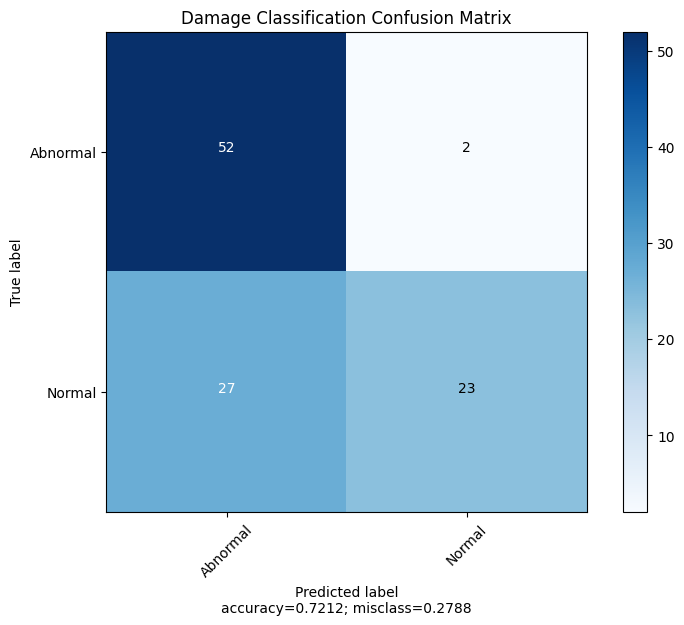

TP:52 TN:2 FP:27 FN:23


In [ ]:
confusionMatrix = confusion_matrix(allLabels, bestPredicted)
plot_confusion_matrix(cm           = confusionMatrix,
                      normalize    = False,
                      target_names = resizeTrainDataset.classes,
                      title        = "Damage Classification Confusion Matrix")
tn, fp, fn, tp = confusionMatrix.ravel()
print('TP:{} TN:{} FP:{} FN:{}'.format(tn, fp, fn, tp))

In [ ]:
def showRandomSamples(labels, predicted, testDataset, sampleNum=5):
  equals = labels == predicted
  correctIdx = np.where(equals == 1)[0].tolist()
  incorrectIdx = np.where(equals == 0)[0].tolist()

  randomCorrectIdx = random.sample(correctIdx, sampleNum)
  randomIncorrectIdx  = random.sample(incorrectIdx, sampleNum)

  _, figure = plt.subplots(2,sampleNum,figsize=(30,10))

  ### Plot Correct ###
  for imageIdx in range(len(randomCorrectIdx)):
    image, className = getImageFromDataset(testDataset, randomCorrectIdx[imageIdx])
    figure[0,imageIdx].imshow(image,cmap='gray')
    figure[0,imageIdx].title.set_text('[CORRECT] '+className)

  for imageIdx in range(len(randomIncorrectIdx)):
    image, className = getImageFromDataset(testDataset, randomIncorrectIdx[imageIdx])
    figure[1,imageIdx].imshow(image,cmap='gray')
    predictedClassName = testDataset.classes[predicted[randomIncorrectIdx[imageIdx]]]
    figure[1,imageIdx].title.set_text('Actual:'+className+' Predicted:' + predictedClassName)

  plt.show()

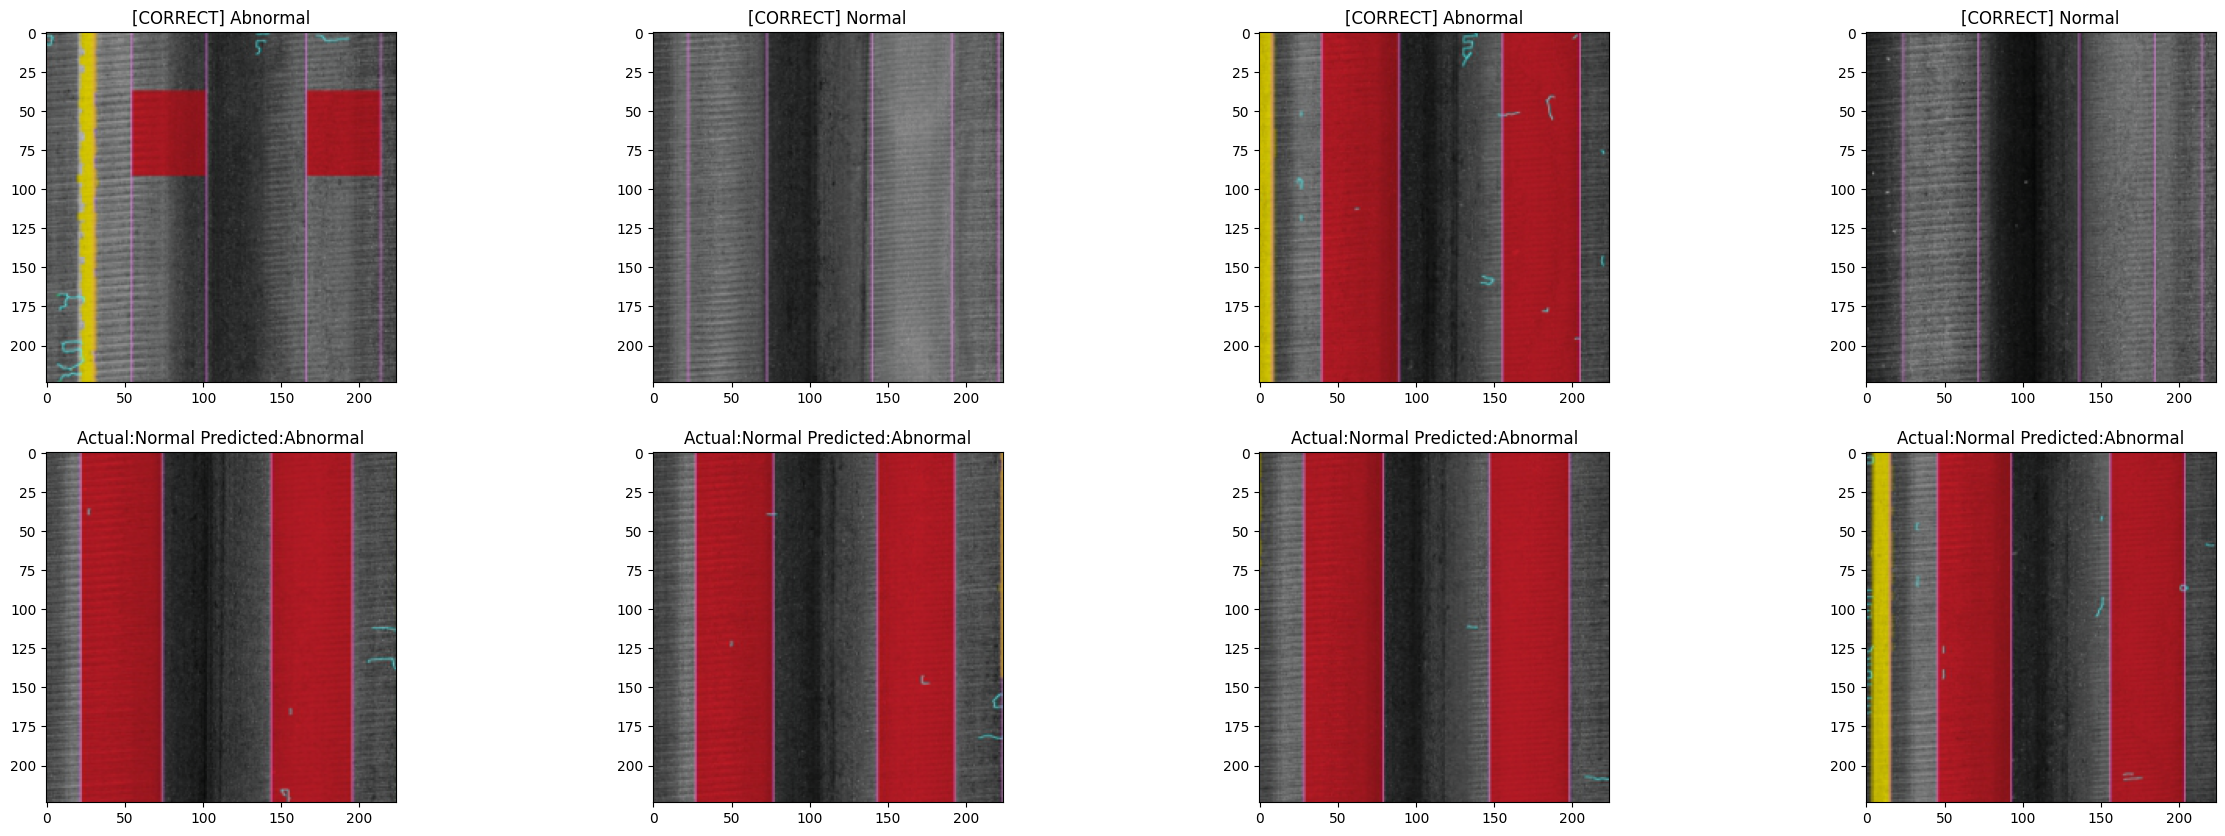

In [ ]:
showRandomSamples(allLabels,bestPredicted,resizeTestDataset,sampleNum=4)

# **Test with ROMDAS**

**Dataset Download**

In [ ]:
#https://drive.google.com/file/d/1zl_CTQrl7gUqRK5PYc1Qqxuc9ZPjesVk/view?usp=sharing
! gdown --id 1zl_CTQrl7gUqRK5PYc1Qqxuc9ZPjesVk
!unzip -qo ROMDAS_TEST.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zl_CTQrl7gUqRK5PYc1Qqxuc9ZPjesVk
To: /content/ROMDAS_TEST.zip
100% 6.73M/6.73M [00:00<00:00, 43.6MB/s]


In [ ]:
transformTest_rom = transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(size=(224,224))])
        #transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [ ]:
resizeTestDataset_Rom = ImageFolder('/content/ROMDAS_TEST',transform = transformTest_rom)

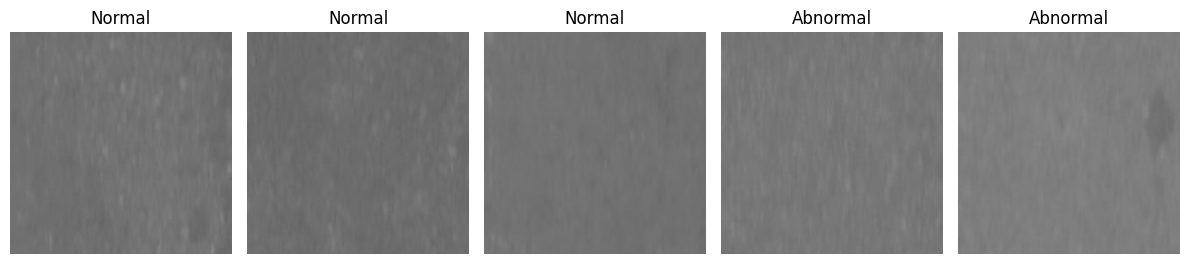

In [ ]:
visualize_dataset(resizeTestDataset_Rom,5)

**Train Model**

In [ ]:
resizeTrainDatasetLoader = DataLoader(resizeTrainDataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
resizeTestDatasetLoader = DataLoader(resizeTestDataset_Rom, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def testModel(testDatasetLoader, net):
  net.eval()
  correctImages = 0
  totalImages = 0
  allLabels = []
  allPredicted = []
  testingProgressbar = tqdm(enumerate(testDatasetLoader), total=len(testDatasetLoader))
  with torch.no_grad():
    for batchIdx, batchData in testingProgressbar:
      images, labels = batchData

      images, labels = images.cuda(), labels.cuda()
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)

      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      testingProgressbar.set_description("Testing accuracy: {}".format(accumulateAccuracy ) )

      allLabels.append(labels)
      allPredicted.append(predicted)
  allLabels = torch.cat(allLabels).cpu().numpy()
  allPredicted = torch.cat(allPredicted).cpu().numpy()
  return correctImages, totalImages, allLabels, allPredicted

def trainAndTestModel(trainDatasetLoader, testDatasetLoader, net, optimizer,scheduler, criterion, trainEpoch):

  bestAccuracy = 0
  correctImages = 0
  totalImages = 0
  for currentEpoch in tqdm(range(trainEpoch), desc='Overall Training Progress:'):
    trainingLoss = 0.0
    net.train()
    print('Epoch',str(currentEpoch+1),'/',str(trainEpoch))
    trainingProgressbar = tqdm(enumerate(trainDatasetLoader), total=len(trainDatasetLoader))
    for batchIdx, batchData in trainingProgressbar:
      images, labels = batchData
      images, labels = images.cuda(), labels.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(images)
      loss = criterion(outputs, labels)

      _, predicted = torch.max(outputs, 1)
      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      loss.backward()
      optimizer.step()


      trainingLoss += loss.item()
      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      trainingProgressbar.set_description("Training accuracy: {} loss: {}".format(accumulateAccuracy, round(loss.item(),4) ) )
    scheduler.step(trainingLoss)
    correctImages, totalImages, allLabels, allPredicted = testModel(testDatasetLoader, net)
    testAccuracy = round((correctImages/totalImages)*100,2)

    print('='*10)

    if testAccuracy > bestAccuracy:
      bestAccuracy = testAccuracy
      bestPredicted = allPredicted
      bestNet = net

  return bestAccuracy, bestPredicted, allLabels, bestNet

In [ ]:
bestAccuracy, bestPredicted, allLabels, bestNet = trainAndTestModel(resizeTrainDatasetLoader, resizeTestDatasetLoader,
                                                                    pneuNet,
                                                                    optimizer, scheduler, criterion,
                                                                    trainEpoch=3)

Overall Training Progress::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 / 3


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2 / 3


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3 / 3


  0%|          | 0/387 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

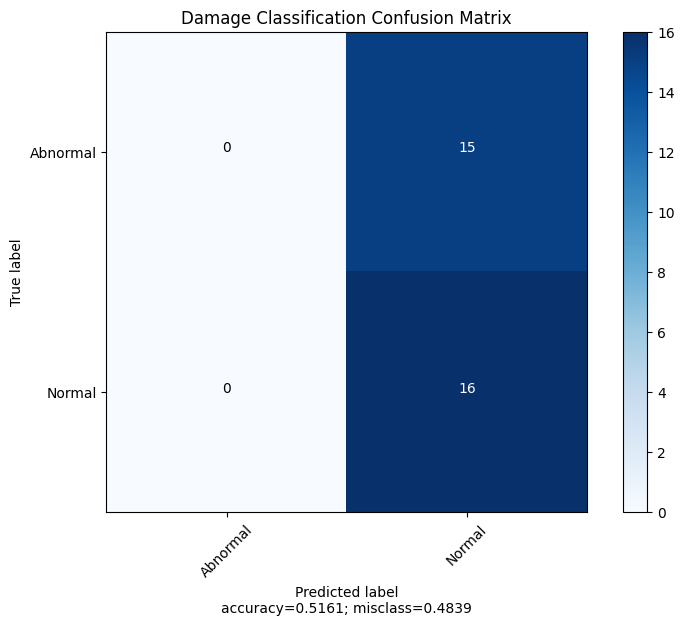

TP:0 TN:15 FP:0 FN:16


In [ ]:
confusionMatrix = confusion_matrix(allLabels, bestPredicted)
plot_confusion_matrix(cm           = confusionMatrix,
                      normalize    = False,
                      target_names = resizeTrainDataset.classes,
                      title        = "Damage Classification Confusion Matrix")
tn, fp, fn, tp = confusionMatrix.ravel()
print('TP:{} TN:{} FP:{} FN:{}'.format(tn, fp, fn, tp))

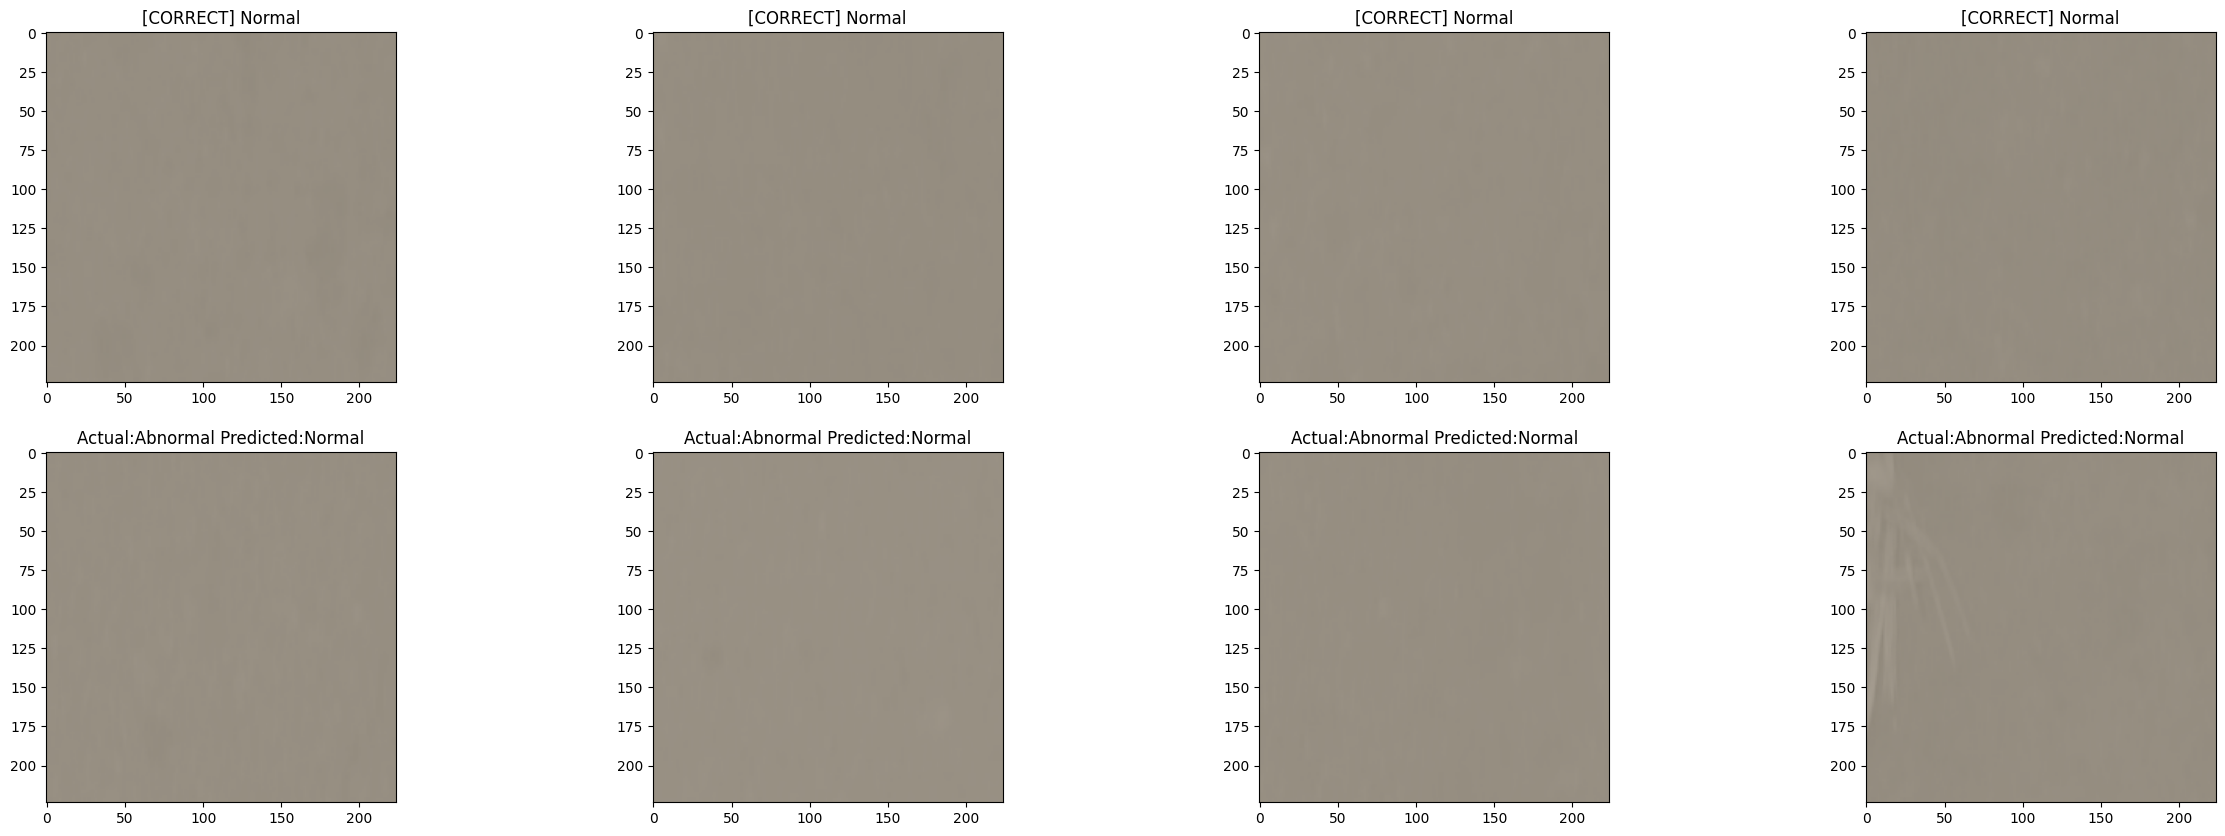

In [ ]:
showRandomSamples(allLabels,bestPredicted,resizeTestDataset_Rom,sampleNum=4)

accuracy บ้าบอคอแตกมาก อยากได้ ai จับรอยมากกก

# **Material Classification**

**Disclaimer: วิธีการคัดแยกที่กำลังใช้นี้ ค่อนข้างไม่สมเหตุสมผล แต่ยังสามารถใช้ตรวจสอบความน่าเชื่อถือของค่าสภาพทางได้ โดยการหา correlation**

In [ ]:
#https://drive.google.com/file/d/1Vq2n7xT2E6vn9br9rv83d8cnDv2VyxGy/view?usp=sharing
! gdown --id 1Vq2n7xT2E6vn9br9rv83d8cnDv2VyxGy

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Vq2n7xT2E6vn9br9rv83d8cnDv2VyxGy
To: /content/raw_data.csv
100% 18.3k/18.3k [00:00<00:00, 49.8MB/s]


**setting environment and import dataset**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data = pd.read_csv('/content/raw_data.csv', index_col=False)

In [ ]:
data

,FRAME,Z,HEADING
0,1,40.51,334.53
1,2,40.54,334.48
2,3,40.57,334.11
3,4,40.59,333.92
4,5,40.61,333.71
...,...,...,...
1026,1027,40.30,350.23
1027,1028,40.32,350.22
1028,1029,40.32,350.30
1029,1030,40.31,350.41


**visualize our dataset**

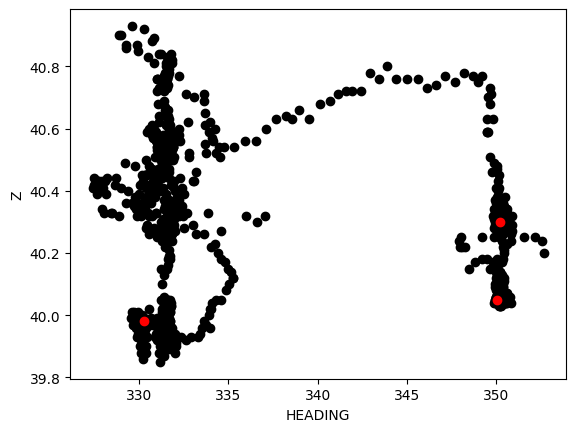

In [ ]:
Centroids = (data.sample(n=3))
plt.scatter(data["HEADING"],data["Z"],c='black')
plt.scatter(Centroids["HEADING"],Centroids["Z"],c='red')
plt.xlabel('HEADING')
plt.ylabel('Z')
plt.show()

**1. K-mean Classification**








*   centroid - based with variance normalization
*   very simple algorithm



In [ ]:
# copy actual data first so the real data doesn't change
datacopy = data

In [ ]:
diff = 1
j=0
K =3 #number of clusters you want to classify
while(diff!=0):
    XD=datacopy
    i=1
    for index1,row_c in Centroids.iterrows():
        ED=[]
        for index2,row_d in XD.iterrows():
            d1=(row_c["HEADING"]-row_d["HEADING"])**2
            d2=(row_c["Z"]-row_d["Z"])**2
            d=np.sqrt(d1+d2)
            ED.append(d)
        datacopy[i]=ED
        i=i+1

    C=[]
    for index,row in data.iterrows():
        min_dist=row[1]
        pos=1
        for i in range(K):
            if row[i+1] < min_dist:
                min_dist = row[i+1]
                pos=i+1
        C.append(pos)
    datacopy["Cluster"]=C
    Centroids_new = datacopy.groupby(["Cluster"]).mean()[["Z","HEADING"]]
    if j == 0:
        diff=1
        j=j+1
    else:
        diff = (Centroids_new['Z'] - Centroids['Z']).sum() + (Centroids_new['HEADING'] - Centroids['HEADING']).sum()
        print(diff.sum())
    Centroids = datacopy.groupby(["Cluster"]).mean()[["Z","HEADING"]]

-2.0741719306633044
-1.8075212375126668
-2.1658986084114176
-1.29858659805965
-0.7334407167934529
-0.4970820167310208
-0.2037350502929769
0.0


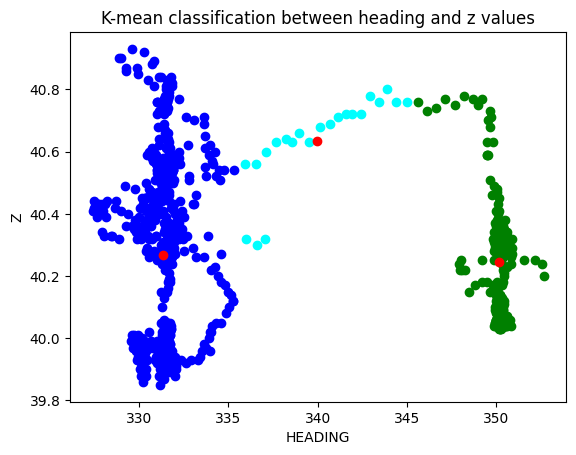

In [ ]:
color=['blue','green','cyan']
for k in range(K):
    dataja=datacopy[datacopy["Cluster"]==k+1]
    plt.scatter(dataja["HEADING"],dataja["Z"],c=color[k])
plt.scatter(Centroids["HEADING"],Centroids["Z"],c='red')
plt.xlabel('HEADING')
plt.ylabel('Z')
plt.title('K-mean classification between heading and z values')
plt.show()

**2. DBSCBN**



*   density - based better working with weird shape clustering with noise



**data extraction**

In [ ]:
# extracting the above mentioned columns
x = data.loc[:, ['HEADING',
                 'Z']].values

In [ ]:
x.shape

(1031, 2)

**compute the nearest neighbor analysis to determine eps**

In [ ]:
from sklearn.neighbors import NearestNeighbors # importing the library
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(x) # fitting the data to the object
distances,indices=nbrs.kneighbors(x) # finding the nearest neighbours

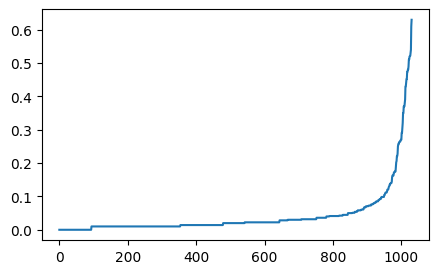

In [ ]:
# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

we found that maximum curvature is 0.25 so **ept = 0.25**

**model implementing**

In [ ]:
from sklearn.cluster import DBSCAN
# cluster the data into five clusters
dbscan = DBSCAN(eps = 0.25, min_samples = 4).fit(x) # fitting the model
labels = dbscan.labels_ # getting the labels

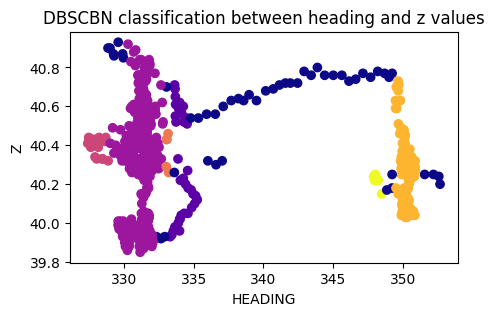

In [ ]:
# Plot the clusters
plt.scatter(x[:, 0], x[:,1], c = labels, cmap= "plasma") # plotting the clusters
plt.xlabel("HEADING") # X-axis label
plt.ylabel("Z") # Y-axis label
plt.title('DBSCBN classification between heading and z values')
plt.show() # showing the plot

**3. สร้าง decision model (Tree) ของค่าที่ได้เพื่อจัดหมวดหมู่ label**

น่าเสียดายที่ข้อมูลที่ได้มามีแต่ลาดยาง แทบไม่มี concrete เลย แต่ classify นี้ สามารถแยกเสถียรภาพของถนนได้เป็น 3 ช่วง ดังนั้น 1, 2, 3 จะแทนช่วงถนนที่สั้นไม่สม่าเสมอกัน 3 ช่วง

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

**concatenete the classification from k - mean**

In [ ]:
datacopy["Cluster"]

0       1
1       1
2       1
3       1
4       1
       ..
1026    2
1027    2
1028    2
1029    2
1030    2
Name: Cluster, Length: 1031, dtype: int64

In [ ]:
datade = pd.merge(data,datacopy["Cluster"], left_index=True, right_index=True).drop(columns = [1,2,3,'Cluster_y'])
datade.rename(columns = {'Cluster_x':'Cluster'}, inplace = True)

In [ ]:
datade

,FRAME,Z,HEADING,Cluster
0,1,40.51,334.53,1
1,2,40.54,334.48,1
2,3,40.57,334.11,1
3,4,40.59,333.92,1
4,5,40.61,333.71,1
...,...,...,...,...
1026,1027,40.30,350.23,2
1027,1028,40.32,350.22,2
1028,1029,40.32,350.30,2
1029,1030,40.31,350.41,2


In [ ]:
datade.columns

Index(['FRAME', 'Z', 'HEADING', 'Cluster'], dtype='object')

In [ ]:
X = datade[['HEADING','Z']] # Features
y = datade.Cluster # Target variable

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [ ]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 1.0


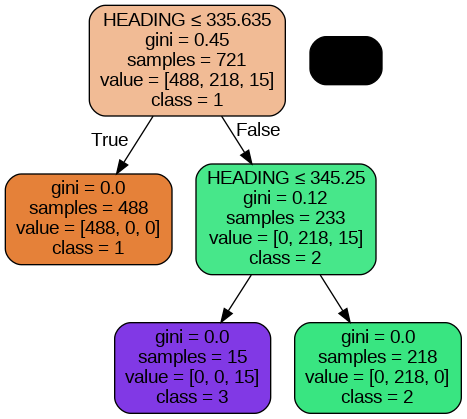

In [ ]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus

feature_cols = ['HEADING','Z']
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['1','2','3'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('tree.png')
Image(graph.create_png())

**4. ตรวจสอบ correlation ค่าสภาพทาง**

In [ ]:
import seaborn as sns

In [ ]:
#https://drive.google.com/file/d/1MzPLiFkxOnUtEmZSPuXk2QfK3d9S0D-g/view?usp=sharing
! gdown --id 1MzPLiFkxOnUtEmZSPuXk2QfK3d9S0D-g

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1MzPLiFkxOnUtEmZSPuXk2QfK3d9S0D-g
To: /content/Value.csv
100% 31.8k/31.8k [00:00<00:00, 58.4MB/s]


In [ ]:
Value = pd.read_csv('/content/Value.csv')

In [ ]:
Value

,CHAINAGE,IRI,IRI_LANE,RUTTING,TEXT,EDTTEXT
0,0,1.45,1.45,1.38,0.32,0.26
1,5,2.11,2.11,1.57,0.38,0.31
2,10,2.51,2.51,1.86,0.45,0.37
3,15,3.36,3.36,2.42,0.52,0.42
4,20,3.70,3.70,2.76,0.58,0.47
...,...,...,...,...,...,...
1031,5155,2.20,2.20,6.97,0.32,0.26
1032,5160,1.60,1.60,5.89,0.28,0.23
1033,5165,1.47,1.47,5.00,0.24,0.19
1034,5170,1.24,1.25,4.22,0.20,0.16


In [ ]:
# preparing data that includes all variable needed
dataco = pd.merge(data[['HEADING','Z']],Value, left_index=True, right_index=True).drop(columns = ['CHAINAGE'])

In [ ]:
dataco

,HEADING,Z,IRI,IRI_LANE,RUTTING,TEXT,EDTTEXT
0,334.53,40.51,1.45,1.45,1.38,0.32,0.26
1,334.48,40.54,2.11,2.11,1.57,0.38,0.31
2,334.11,40.57,2.51,2.51,1.86,0.45,0.37
3,333.92,40.59,3.36,3.36,2.42,0.52,0.42
4,333.71,40.61,3.70,3.70,2.76,0.58,0.47
...,...,...,...,...,...,...,...
1026,350.23,40.30,3.89,3.89,7.89,0.43,0.35
1027,350.22,40.32,3.74,3.75,7.52,0.40,0.33
1028,350.30,40.32,3.56,3.56,7.57,0.38,0.31
1029,350.41,40.31,2.99,2.99,7.97,0.37,0.30


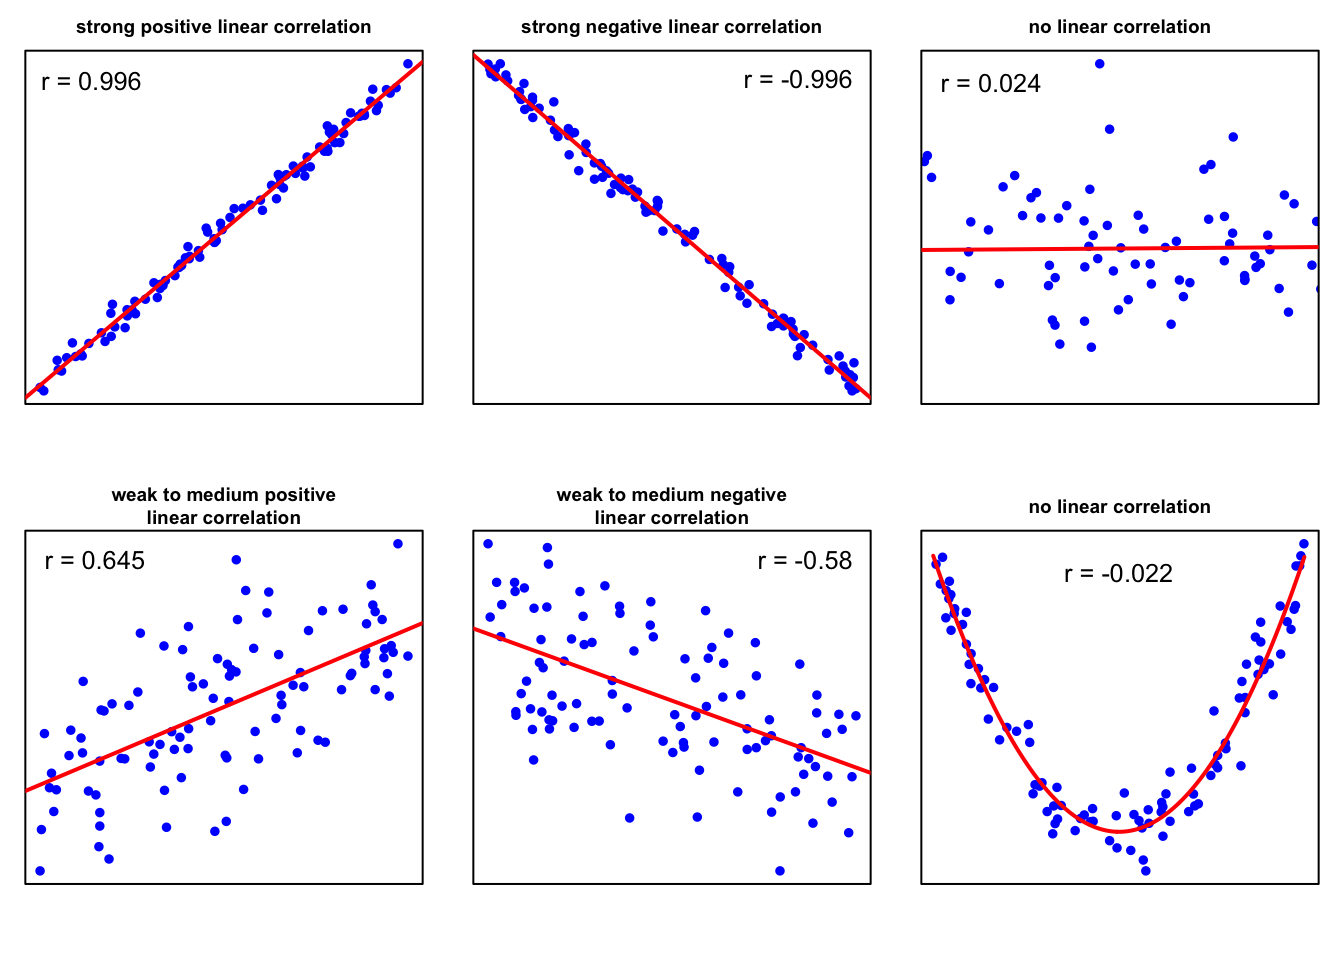

In [ ]:
# correlation matrix
corre = dataco.corr()
round(corre,2)

,HEADING,Z,IRI,IRI_LANE,RUTTING,TEXT,EDTTEXT
HEADING,1.00,-0.04,-0.16,-0.16,0.25,-0.32,-0.31
Z,-0.04,1.00,-0.03,-0.03,-0.66,-0.31,-0.31
IRI,-0.16,-0.03,1.00,1.00,-0.12,0.48,0.48
IRI_LANE,-0.16,-0.03,1.00,1.00,-0.12,0.48,0.48
RUTTING,0.25,-0.66,-0.12,-0.12,1.00,0.01,0.01
TEXT,-0.32,-0.31,0.48,0.48,0.01,1.00,1.00
EDTTEXT,-0.31,-0.31,0.48,0.48,0.01,1.00,1.00


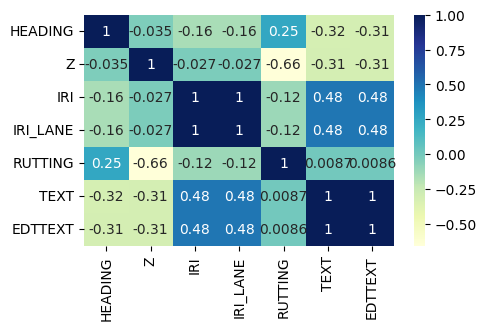

In [ ]:
sns.heatmap(corre, cmap="YlGnBu", annot=True);

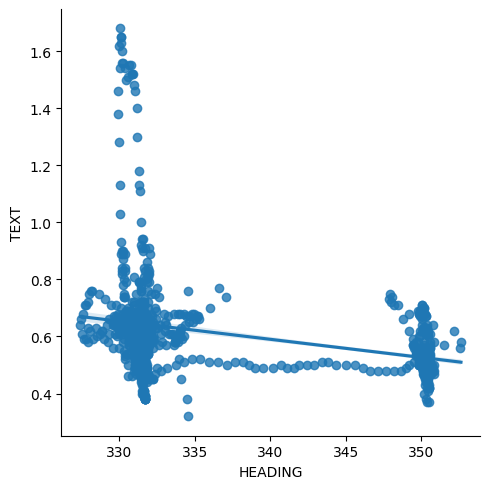

In [ ]:
sns.lmplot(x='HEADING', y='TEXT', data=dataco);

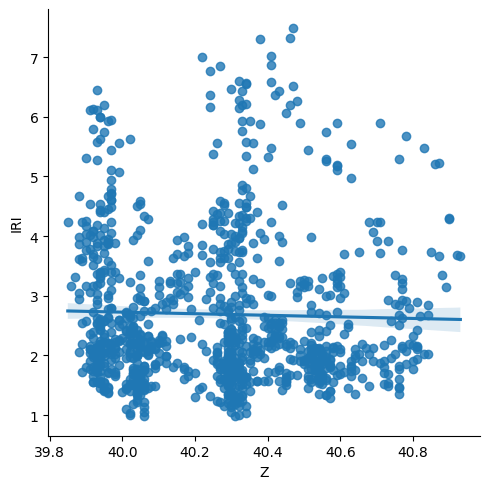

In [ ]:
sns.lmplot(x='Z', y='IRI', data=dataco);